In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nnfs.datasets import vertical_data

In [2]:
vertical_data??

Signature: vertical_data(samples, classes)
Docstring: <no docstring>
Source:   
def create_data(samples, classes):
    X = np.zeros((samples*classes, 2))
    y = np.zeros(samples*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(samples*class_number, samples*(class_number+1))
        X[ix] = np.c_[np.random.randn(samples)*.1 + (class_number)/3, np.random.randn(samples)*.1 + 0.5]
        y[ix] = class_number
    return X, y
File:      /opt/homebrew/anaconda3/lib/python3.12/site-packages/nnfs/datasets/vertical.py
Type:      function

In [3]:

x,y = vertical_data(samples = 300,classes = 3)

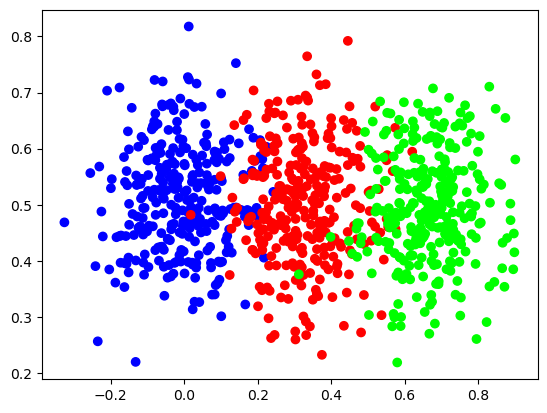

In [4]:
plt.scatter(x[:,0],x[:,1],c = y,cmap='brg')

In [26]:
class Dense:
    def __init__(self,no_of_inputs,no_of_neurons):
        self.no_of_inputs = no_of_inputs
        self.no_of_neurons = no_of_neurons
        self.weights = np.array(np.random.rand(self.no_of_inputs,self.no_of_neurons)) * 0.01
        self.bias = np.array(np.random.rand(1,self.no_of_neurons))

    def forward(self,inputs):
        self.inputs = inputs
        self.output = self.inputs@self.weights + self.bias

    def backward(self,dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis = 0,keepdims = True)
        self.dinputs = np.dot(dvalues,self.weights.T)



class Activation_Relu:
    def forward(self,Dense_output):
        self.inputs = Dense_output
        self.activation_output = np.maximum(0,Dense_output)

    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs < 0] = 0


class Softmax:
    def forward(self,y_pred):
        y_pred = y_pred - np.max(y_pred,axis=1,keepdims=True)
        self.exp = np.exp(y_pred) 
        self.sum_rows = np.sum(self.exp,axis=1,keepdims=True)
        self.output = self.exp / self.sum_rows



class CrossEntropyLoss:
    def forward(self,y_pred,y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred,1e-7,1-1e-7)
        if len(y_true.shape) == 1:
            self.output = -np.mean(np.log(y_pred[range(samples),y_true]))
        elif len(y_true.shape) == 2:
            self.output = -np.mean(np.log(np.sum(y_pred*y_true,axis=1)))

    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        self.dinputs = -y_true/dvalues
        self.dinputs = self.dinputs/samples




In [27]:
class Activation_Softmax_CategoricalCrossentropy:
    def __init__(self):
        self.activaton = Softmax()
        self.loss = CrossEntropyLoss()

    def forward(self,inputs,y_true):
        self.activaton.forward(inputs)
        self.output = self.activaton.output

        return self.loss.forward(self.output,y_true)
    
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)

        self.inputs = dvalues.copy()
        self.inputs[range(samples),y_true] -= 1

        self.inputs = self.inputs / samples


In [28]:
softmax_outputs = np.array([[0.7,0.1,0.2],
                            [0.1,0.5,0.4],
                            [0.02,0.9,0.08]])
class_targets = np.array([0,1,2])
softmax_loss = Activation_Softmax_CategoricalCrossentropy()
softmax_loss.backward(softmax_outputs,class_targets)
dvalues1 = softmax_loss.inputs
print(dvalues1)

[[-0.1         0.03333333  0.06666667]
 [ 0.03333333 -0.16666667  0.13333333]
 [ 0.00666667  0.3        -0.30666667]]


In [6]:
# x,y is our inputs for vertical Dataset
# creating the model

layer1 = Dense(2,3)
layer1_relu = Activation_Relu()
layer2 = Dense(3,3)
layer2_softmax = Softmax()

loss_function = CrossEntropyLoss()
lowest_loss = 999999
best_w_layer1 = layer1.weights.copy()
best_b_layer1 = layer1.bias.copy()
best_w_layer2 = layer2.weights.copy()
best_b_layer2 = layer2.bias.copy()

In [7]:
# staring the model for 100000 iterations
for iterations in range(100000):
    layer1.weights += 0.05*np.random.randn(2,3)
    layer1.bias += 0.05*np.random.randn(1,3)
    layer2.weights += 0.05*np.random.randn(3,3)
    layer2.bias += 0.05*np.random.randn(1,3)

    layer1.forward(x)
    layer1_relu.forward(layer1.output)
    layer2.forward(layer1_relu.activation_output)
    layer2_softmax.forward(layer2.output)

    loss_function.forward(layer2_softmax.output,y)

    if loss_function.output < lowest_loss:
        lowest_loss = loss_function.output
        prediction = np.argmax(layer2.output,axis=1)
        accuracy = np.mean(prediction == y)
        print(f"at iteration {iterations+1} loss = {loss_function.output} accuracy = {accuracy}")
        best_w_layer1 = layer1.weights.copy()
        best_b_layer1 = layer1.bias.copy()
        best_w_layer2 = layer2.weights.copy()
        best_b_layer2 = layer2.bias.copy()

    else:
        layer1.weights = best_w_layer1.copy()
        layer1.bias = best_b_layer1.copy()
        layer2.weights = best_w_layer2.copy()
        layer2.bias = best_b_layer2.copy()




at iteration 1 loss = 1.1148971374328656 accuracy = 0.3333333333333333
at iteration 3 loss = 1.1003471246560168 accuracy = 0.3333333333333333
at iteration 8 loss = 1.0999317531136328 accuracy = 0.3333333333333333
at iteration 9 loss = 1.0986736287073806 accuracy = 0.3333333333333333
at iteration 10 loss = 1.0970277368590797 accuracy = 0.3333333333333333
at iteration 19 loss = 1.0948201295935343 accuracy = 0.3511111111111111
at iteration 20 loss = 1.0925306509388721 accuracy = 0.3333333333333333
at iteration 22 loss = 1.0873565419960836 accuracy = 0.5488888888888889
at iteration 23 loss = 1.086183269480924 accuracy = 0.6266666666666667
at iteration 34 loss = 1.0857562507718101 accuracy = 0.3488888888888889
at iteration 39 loss = 1.0838486211141036 accuracy = 0.6144444444444445
at iteration 44 loss = 1.0831656000258414 accuracy = 0.3333333333333333
at iteration 45 loss = 1.0762934799333668 accuracy = 0.3333333333333333
at iteration 47 loss = 1.0660324226145859 accuracy = 0.33333333333333

Thsis Stratergy only works on simpler datasets it wont work on spiral datasets